<a href="https://colab.research.google.com/github/benedettacandelori/Monkeys_go_stop_trials/blob/main/transformers_1D_time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import scipy.io
import os
import math
import torch

In [4]:
os.chdir('/content/drive/MyDrive')
os.getcwd() 

'/content/drive/MyDrive'

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [6]:
%pip install pytorch_lightning einops seaborn --quiet
!pip install positional-encodings[pytorch,tensorflow]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import math
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from torch import nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import pytorch_lightning as pylight
from einops.layers.torch import Rearrange
from einops import reduce, rearrange, repeat
from positional_encodings.torch_encodings import PositionalEncoding1D, PositionalEncoding2D, PositionalEncoding3D, Summer
from torchmetrics.classification import Accuracy, F1Score, MulticlassAccuracy,BinaryAccuracy

# Dataset

### Dataset creation

In [8]:
class Monkeys_dataset(Dataset):
    """Monkeys dataset"""

    def __init__(self, mat_file_labels, mat_file_x, root_dir, start_idx = 800, end_idx = 1200):
        """
        Args:
            mat_file (string): Path to the .mat files.
            root_dir (string): Directory with all the data.
        """
        self.classes = scipy.io.loadmat(mat_file_labels)['nostop']
        self.data = scipy.io.loadmat(mat_file_x)['matrix']
        self.root_dir = root_dir
        self.start_idx = start_idx
        self.end_idx = end_idx

    def __len__(self):
        return len(self.classes)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()


        x = self.data[:,idx,self.start_idx:self.end_idx]
        x = torch.tensor(x).float().squeeze(0)#.unsqueeze(1) 
        label = int(self.classes[idx,1])
      
        #sample = {'matrix': x, 'class': label}
        sample = (x, label)

        return sample

In [9]:
start= 300
end = 700

In [10]:
dataset = Monkeys_dataset(mat_file_labels = 'Stop_Task_Collab_2023/BHV_Go.mat', mat_file_x = 'Stop_Task_Collab_2023/activity_movement_onset_Go.mat',
                                    root_dir='Stop_Task_Collab_2023/', start_idx = start, end_idx = end)


In [11]:
print(dataset[0][0].shape)
print(dataset[0][1])

torch.Size([105, 400])
2


### Data loader

In [12]:
# We split the dataset in training and test portions
monkey_train, monkey_val, monkey_test = torch.utils.data.random_split(dataset, [0.7, 0.2, 0.1])

In [13]:
batch_size = 8

In [14]:
# Loaders create mini-batches of images from the original dataset
loader_train = torch.utils.data.DataLoader(monkey_train, batch_size=batch_size, shuffle=True,)
loader_val = torch.utils.data.DataLoader(monkey_val, batch_size=batch_size, shuffle=False)
loader_test = torch.utils.data.DataLoader(monkey_test, batch_size=batch_size, shuffle=False)

In [15]:
for xb, yb in loader_train:
  break
print(xb.shape)
print(yb.shape)

torch.Size([8, 105, 400])
torch.Size([8])


# Transformer 1: embedding + encoder block 



*   embedding con con1d, positional encoding
*   encoder over the time dimension


Modello non valido, loss non scende durante il training


In [ ]:
class Embedding(nn.Module):
  def __init__(self, d_output, d_space: int = 105, d_time: int = 400, max_len = 5000, dropout: float = 0.1):
    # Input is (BATCH, NEURONS, TIME), output should be (BATCH, NEURONS, TIME, D_OUTPUT)
    super().__init__()
    self.dropout = nn.Dropout(p=dropout)
    # From the point of view of the stem, the input is (1, TIME), where 1 are the channels, so the first convolution should have filter size 1
    self.stem = nn.Sequential(nn.Conv1d(1, d_output//2, 1, padding=1), nn.ReLU(), nn.Conv1d(d_output//2, d_output, 5, padding=1))
    # Trainable (TODO: improve initialization)
    self.pos_enc_trainable = nn.Parameter(torch.randn((d_space, d_time, d_output), requires_grad=True))

    self.d_space = d_space
    ##########

    # Not trainable positional encoding
    self.pos_enc_2d = PositionalEncoding2D(d_output)

  def forward(self, x):
    # Add neurons to the batch dimension
    #print('input x: ', x.shape)
    x = rearrange(x, 'b neurons time -> (b neurons) 1 time')
    x = self.stem(x) 

    # Rearrange to the original shape to add positional embeddings
    x = rearrange(x,'(b neurons) out time -> b neurons time out', neurons=self.d_space)
    #print('post stem x: ', x.shape)
    #print('pos enc train: ', self.pos_enc_trainable.shape)
    pos_enc = self.pos_enc_2d(x)
    #print('pos enc not train: ', pos_enc.shape)
    x = x + pos_enc + self.pos_enc_trainable 

    return self.dropout(x)

In [ ]:
# Sanity check
#Embedding(16)(xb).shape

In [ ]:
class TransformerBlock(nn.Module):
  def __init__(self, d_input, d_hidden):
    super().__init__()
    self.sa = nn.MultiheadAttention(embed_dim=d_input, num_heads=4, batch_first=True)
    self.ln1 = nn.LayerNorm(d_input)
    self.ln2 = nn.LayerNorm(d_input)
    self.dense = nn.Sequential(
        nn.Linear(d_input, d_hidden*4),
        nn.GELU(),
        nn.Linear(d_hidden*4, d_input)
    )

  def forward(self, x):
    x = self.ln1(x)
    x_t, a = self.sa(x, x, x)
    x = x_t + x
    x = self.dense(self.ln2(x)) + x
    return x, a

In [ ]:
from torch.functional import align_tensors
class Transformer(pylight.LightningModule):

  def __init__(self, d_space: int = 105, d_time: int = 400,n_classes=2, hidden_dimension=16):
    super().__init__()
    self.d_space = d_space
    self.d_time = d_time
    self.input_embedding = Embedding(hidden_dimension)
    self.time = TransformerBlock(hidden_dimension, hidden_dimension)
    self.space = TransformerBlock(hidden_dimension, hidden_dimension)
    self.classifier = nn.Linear(hidden_dimension, n_classes)

    self.acc = BinaryAccuracy()

  def forward(self, x):
    #print('input ',x.shape)
    x = self.input_embedding(x)
    #print('post embedding ',x.shape)
    # First block is over time
    x = rearrange(x, 'b neurons time out -> (b neurons) time out')
    #print('rearrenge space ',x.shape)
    x, a_s = self.space(x)
    #print('space transfomrer ',x.shape)
    #print('att map ',a_s.shape)
    # Next block is over neurons
    #print('input ',x.shape)
    #x = rearrange(x, '(b neurons) time out -> (b time) neurons out', neurons=self.d_space)
    #print('rearrenge time ',x.shape)
    #x, a_t = self.time(x)
    #print('time transformer ',x.shape)

    # Reduction over neurons and time
    x = reduce(x, '(b neurons) time out -> b out', neurons=self.d_space, reduction='mean')
    #print('reduce finale ',x.shape)
    #print('output ',self.classifier(x))
    return self.classifier(x), a_s#, a_t


  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr = 0.001) 

  def training_step(self, batch, batch_idx):
    xb, yb = batch
    yb = F.one_hot(yb-1, num_classes=2) 

    y_pred, a_s= self(xb)

    loss = F.cross_entropy(y_pred.float(), yb.float())
    acc = self.acc(y_pred, yb)
    print('train loss ',loss,' ------ train acc', acc)


    self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    self.log("train_acc", acc, on_step=True, on_epoch=False, prog_bar=True)
    return loss#, a_s, a_t

  def validation_step(self, batch, batch_idx):
    xb, yb = batch
    yb = F.one_hot(yb-1, num_classes=2) 

    y_pred, a_s = self(xb)
    
    acc = self.acc(y_pred, yb)
    loss = F.cross_entropy(y_pred.float(), yb.float())
    print('val loss ',loss,' ------ val acc', acc)

    self.log("val_loss", loss)
    self.log("val_acc", acc)
    return loss

  def test_step(self, batch, batch_idx):
    xb, yb = batch
    yb = F.one_hot(yb-1, num_classes=2) 
    y_pred, a_s = self(xb)
    
    self.acc(y_pred, yb)
    self.log("test_acc", self.acc, on_step=True, on_epoch=True, prog_bar=True)
    return self.acc

In [ ]:
# Sanity check
#out, a_s= Transformer()(xb)

In [ ]:
out.shape

torch.Size([8, 2])

In [ ]:
a_s.shape

torch.Size([840, 400, 400])

### Training

In [ ]:
model = Transformer()
trainer = pylight.Trainer(max_epochs=50, accelerator='gpu', devices=1,default_root_dir="/content/drive/MyDrive/")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, loader_train, loader_val)

Provare a trainare molto a lungo

In [ ]:
trainer.test(model, dataloaders=loader_test)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │            0.5            │
└───────────────────────────┴───────────────────────────┘

[{'test_acc_epoch': 0.5}]

# Transformer 2: no embedding + encoder block - only over the time dimension

- no embedding dei dati, n
- non viene aggiunto positional encoding
- solo 1 encoder block sulla dimensione temporale

In [28]:
class TransformerBlock(nn.Module):
  def __init__(self, d_input, d_hidden):
    super().__init__()
    self.sa = nn.MultiheadAttention(embed_dim=d_input, num_heads=5, batch_first=True)
    self.ln1 = nn.LayerNorm(d_input)
    self.ln2 = nn.LayerNorm(d_input)
    self.dense = nn.Sequential(
        nn.Linear(d_input, d_hidden*5),
        nn.GELU(),
        nn.Linear(d_hidden*5, d_input)
    )

  def forward(self, x):
    x = self.ln1(x)
    x_t, a = self.sa(x, x, x)
    x = x_t + x
    x = self.dense(self.ln2(x)) + x
    return x, a

In [36]:
from torch.functional import align_tensors
class Transformer(pylight.LightningModule):

  def __init__(self, d_space: int = 105, d_time: int = 400,n_classes=2, dropout = 0.1, learning_rate = 0.00001):
    super().__init__()
    self.d_space = d_space
    self.d_time = d_time
    self.space = TransformerBlock(d_space, d_space)
    self.classifier = nn.Linear(d_time*d_space, n_classes)
    self.flatten = nn.Flatten()
    self.dropout = nn.Dropout(dropout)
    self.acc = BinaryAccuracy()

    self.lr = learning_rate 

  def forward(self, x):
    x = torch.permute(x, (0, 2, 1))
    x, a_s = self.space(x)
    x = self.dropout(x)
    x = self.flatten(x)
    return self.classifier(x), a_s
  
  @torch.no_grad()
  def get_attention_map(self, batch):
      """Function for extracting the attention matrices of the whole Transformer for a single batch.
      Input arguments same as the forward pass.
      """
      xb, yb = batch
      _, att_map = self(xb)
      
      return att_map

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr = self.lr) 

  def training_step(self, batch, batch_idx):
    xb, yb = batch
    yb = F.one_hot(yb-1, num_classes=2) 

    y_pred, _= self(xb)

    loss = F.cross_entropy(y_pred.float(), yb.float())
    acc = self.acc(y_pred, yb)
    
    values = {"train loss": loss, "train acc": acc} 
    self.log_dict(values, prog_bar=True, on_epoch=True, on_step=False)
    return loss

  def validation_step(self, batch, batch_idx):
    xb, yb = batch
    yb = F.one_hot(yb-1, num_classes=2) 

    y_pred, _ = self(xb)
    
    acc = self.acc(y_pred, yb)
    loss = F.cross_entropy(y_pred.float(), yb.float())
    
    values = {"val_loss": loss, "val_acc": acc}
    self.log_dict(values, prog_bar=True, on_epoch=True, on_step=False)
    return loss

  def test_step(self, batch, batch_idx):
    xb, yb = batch
    yb = F.one_hot(yb-1, num_classes=2) 
    y_pred, a_s = self(xb)
    
    self.acc(y_pred, yb)
    #self.log("test acc", self.acc, on_step=False, on_epoch=True, prog_bar=True)
    return self.acc

In [ ]:
# Sanity check
#out, a_s= Transformer()(xb)
#print(out.shape)
#print(a_s.shape)

### Training

In [ ]:
#Hyperparamters
bs = 8
n_epochs = 25
lr = 0.00001

In [ ]:
configuration = "b="+str(bs)+",ep="+str(n_epochs)+",lr="+str(lr)
lag = np.arange(0,400,50)
start = 450
end = 850
for idx, lag in enumerate(lag):
  range_ms = str(1000-(start-lag))+'-'+str(1000-(end-lag))
  print('Start training... for the range of ms before the moviment: ', range_ms)

  dataset = Monkeys_dataset(mat_file_labels = 'Stop_Task_Collab_2023/BHV_Go.mat', mat_file_x = 'Stop_Task_Collab_2023/activity_movement_onset_Go.mat',
                                    root_dir='Stop_Task_Collab_2023/', start_idx = start-lag, end_idx = end-lag)
  
  monkey_train, monkey_val, monkey_test = torch.utils.data.random_split(dataset, [0.7, 0.2, 0.1])
  # Loaders create mini-batches of images from the original dataset
  loader_train = torch.utils.data.DataLoader(monkey_train, batch_size=batch_size, shuffle=True,)
  loader_val = torch.utils.data.DataLoader(monkey_val, batch_size=batch_size, shuffle=False)
  loader_test = torch.utils.data.DataLoader(monkey_test, batch_size=batch_size, shuffle=False)
  
  logger = pylight.loggers.TensorBoardLogger(save_dir='.', version=configuration+'-'+range_ms, name='Transformer_time_logs')
  model = Transformer(learning_rate = lr)
  trainer = pylight.Trainer(max_epochs=n_epochs, accelerator='gpu', devices=1,default_root_dir="/content/drive/MyDrive/", logger=logger)
  trainer.fit(model, loader_train, loader_val)

## Results in TensorBoard

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=Transformer_time_logs/
# !kill 3542

In [ ]:
trainer.test(model, dataloaders=loader_test)

## Attention map


In [37]:
#Hyperparamters
n_epochs = 20
lr = 0.00001

In [38]:
model = Transformer(learning_rate = lr)
trainer = pylight.Trainer(max_epochs=n_epochs, accelerator='gpu', devices=1,default_root_dir="/content/drive/MyDrive/")
trainer.fit(model, loader_train, loader_val)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params
------------------------------------------------
0 | space      | TransformerBlock | 155 K 
1 | classifier | Linear           | 84.0 K
2 | flatten    | Flatten          | 0     
3 | dropout    | Dropout          | 0     
4 | acc        | BinaryAccuracy   | 0     
------------------------------------------------
239 K     Trainable params
0         Non-trainable params
239 K     Total params
0.959     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:

inp_data = F.one_hot(data_input, num_classes=2).float()
inp_data = inp_data.to(device)

In [42]:
batch= next(iter(loader_val))

In [44]:
model.get_attention_map(batch).shape

torch.Size([8, 400, 400])

In [45]:
att = model.get_attention_map(batch)[0]

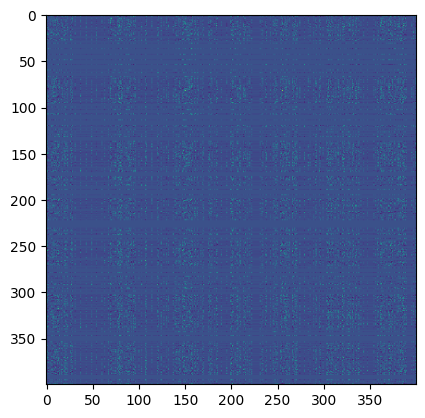

In [46]:
plt.imshow(att)